In [3]:
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_name('Arial')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import seaborn as sns
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit
from scipy.special import i0, i1, iv, kv
import warnings
warnings.filterwarnings("ignore")

In [2]:
def oneReaction(x, k_1_off, C_1_eq):
    """
    A one reaction binding model parameterized by k_off and the equilibrium fraction C_eq
    """
    return 1 - C_1_eq * np.exp(- k_1_off * x)

def twoReactions(x, k_1_off, k_2_off, C_1_eq, C_2_eq):
    """
    A two reaction binding model parameterized by k_offs 1 and 2 and their corresponding equilibrium 
    fractions.
    """
    return 1 - C_1_eq * np.exp(- k_1_off * x) - C_2_eq * np.exp(- k_2_off * x)

def photobleachingProfile(x, r_c, sigma, theta):
    """
    Function for photobleaching profile
    :param x: x vals
    :param r_c: uniform radius
    :param theta: bleaching depth
    :param sigma: sd of normal
    :return: function evaluated on x
    """
    data = np.zeros(x.shape)
    data[x <= r_c] = theta
    data[x > r_c] = 1 + (theta-1) * np.exp(-(x[x > r_c] - r_c)**2 / (2 * sigma**2))
    return data

def computeSingleKon(popt):
    """
    Computes theoretical k_on from k_off and C_eq given fitted parameters popt.
    """
    k_1_off, C_1_eq = popt
    return k_1_off * C_1_eq / (1 - C_1_eq)

def computeKons(popt):
    """
    Computes theoretical k_ons from k_offs and C_eqs given fitted parameters popt. 
    Assumes that k_1_off is less than k_2_off.
    """
    k_1_off,k_2_off,C_1_eq, C_2_eq = popt
    if k_1_off < k_2_off:
        k_1_off,k_2_off,C_1_eq, C_2_eq = k_2_off,k_1_off,C_2_eq,C_1_eq
    return -(k_1_off * C_1_eq) / (C_1_eq + C_2_eq - 1), -(k_2_off * C_2_eq) / (C_1_eq + C_2_eq - 1)

def computeFreeFraction(popt):
    """
    Computes the free fraction F given the bound fractions C_1 and C_2
    """
    if len(popt) == 4:
        return 1 - popt[2] - popt[3]
    elif len(popt) == 2:
        return 1 - popt[1]

def computeKon(C_eq, k_off):
    return C_eq * k_off / (1 - C_eq)

def func(x, tau):
    return np.exp(-tau * x)

## Initialize Model Parameters

In [1]:
BOOTSTRAP_SIZE = 10
BOOTSTRAP_SAMPLES = 100

## Read Files
### File reading functions

In [2]:
def listdir_nohidden(path):
    """
    Helper function from: https://stackoverflow.com/questions/7099290/how-to-ignore-hidden-files-using-os-listdir
    """
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f
            
def read_all_movies(path):
    """
    Reads all movies into a single dataframe
    path (str): a string containing the directory with the data
    returns all_data (structure containing movie data) and names (a list of names)
    """
    all_data = []
    names = []
    for filename in listdir_nohidden(path):
        file = pd.read_csv(path + filename)
        names.append(filename.split(".")[0])
        all_data.append(file)
    for i in range(len(all_data)):
        all_data[i]["label"] = names[i]
    return all_data, names

def export_all_movies(all_data, out_path):
    """
    Exports list of frap dataframes and names as a single csv to out_path. Includes time information
    and intensity measurements.
    """
    relevant_column_dfs = []
    for data in all_data:
        relevant_column_dfs.append(data[["time", "intensity", "label"]])
        
    relevant_columns_concat = pd.concat(relevant_column_dfs)
    relevant_columns_concat.to_csv(out_path)

### Data normalization functions

In [5]:
def normalizeFRAPCurve(data, start_frame, method='Double', prebleach_ss = True):
    """
    Normalizes FRAP curve to be from 0 to 1
    :param data: (series) FRAP curve data
    :param start_frame: (int) Index of bleaching start frame
    :param method: (str) Method of normalization
    :return: (series) Normalized data
    """
    METHODS = ['Fullscale', 'Double']
    if prebleach_ss:
        ss = np.mean(data[:start_frame])

    else:
        ss = np.mean(data[-5:])

    if method == 'Fullscale':
        data = (data - data[start_frame]) / (ss - data[start_frame])
        return data

    if method == 'Double':
        data = data / ss
        return data

    else:
        error_str = 'Method must be one of: ' + ' '.join(METHODS)
        raise ValueError(error_str)
        

def computeGapRatio(data, start_frame):
    """
    Computes gap ratio from frap_img
    :param data: a data object
    :param start_frame: the bleaching frame
    :return: gap ratio
    """
    nonbleach_intensities = data["corrected_nonbleach"]
    return 1 - (np.mean(nonbleach_intensities[-10:]) / np.mean(nonbleach_intensities[:start_frame]))
        
def normalizeAllFRAPCurves(all_data, start_frame, method='Double', prebleach_ss = True):
    """
    Normalizes all FRAP curves contained in all_data. Returns a new
    data structure containing the normalized curves
    :param all_data: structure containing all FRAP data
    :param start_frame: (int) Index of bleaching start frame
    :param method: (str) Method of normalization
    :return: (series) Normalized data
    """
    new_data = []
    all_data_copy = all_data.copy()
    for data in all_data_copy:
        data["intensity"] = normalizeFRAPCurve(data["intensity"], start_frame, method, prebleach_ss)
        nonbleach_cf = data["corrected_nonbleach"]
        nonbleach_cf = np.mean(nonbleach_cf[:start_frame])
        data["corrected_nonbleach"] = data["corrected_nonbleach"] / nonbleach_cf
        
        # fix photobleaching correction
        mean_intensities = data["nonbleach"]
        
        # get original correction factors
        og_intensity_ratios = [intensity / mean_intensities[0] for intensity in mean_intensities]
        intensity_ratios = [intensity / mean_intensities[start_frame] for intensity in mean_intensities]

        # fit exponential decay
        x_data = data["time"]
        og_popt,og_pcov = curve_fit(func, x_data - x_data[0], og_intensity_ratios)
        popt, pcov = curve_fit(func, x_data, intensity_ratios)
        
        # fix gap ratio
        data["gap_ratio"] = computeGapRatio(data, start_frame)
        
        new_data.append(data)
    return new_data
    

### Plotting functions

In [6]:
def plot_single_movie(movie, name, ax=None):
    """
    Plots a single movie's bleaching curve and nonbleaching curve on the same axes
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # make plot
    ax.plot(movie["time"], movie["intensity"])
    ax.plot(movie["time"], movie["corrected_nonbleach"])
    
    # add labels
    ax.set_title(name)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Normalized Intensity")
    ax.legend(["Bleached ROI", "Nonbleached Nuclear ROI"])
    
def plot_single_bleach_profile(movie, name, ax=None):
    """
    Plots a single movie's bleaching profile as a function of radial distance
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # make plot
    ax.plot(movie["bleach_distances"], movie["bleach_profile"])
    ax.axvline(x=movie["radius_uniform"][0], linestyle='--', color='k')
    
    # add labels
    ax.set_title(name)
    ax.set_xlabel("Radial Distance [um]")
    ax.set_ylabel("Normalized Intensity")
    
def plot_all_plots_square(all_data, names):
    """
    Plots all profiles in a square 
    """
    # get dimensions of square
    n_experiments = len(names)
    sq_dim = int(np.ceil(np.sqrt(n_experiments)))
    
    # make subplots with movies
    fig, ax = plt.subplots(sq_dim, sq_dim)
    fig.set_size_inches(20.0, 12.5)
    for i in range(n_experiments):
        plot_single_movie(all_data[i], names[i], ax[i//sq_dim, i%sq_dim])
    plt.subplots_adjust(bottom=0.0, top=1.2)
    plt.show()
    
def plot_all_radial_profiles_square(all_data, names):
    """
    Plots all radial profiles in a square
    """
    # get dimensions of square
    n_experiments = len(names)
    sq_dim = int(np.ceil(np.sqrt(n_experiments)))
    
    # make subplots with radial profiles
    fig, ax = plt.subplots(sq_dim, sq_dim)
    fig.set_size_inches(20.0, 12.5)
    for i in range(n_experiments):
        plot_single_bleach_profile(all_data[i], names[i], ax[i//sq_dim, i%sq_dim])
    plt.subplots_adjust(bottom=0.0, top=1.2)
    plt.show()
    
def plot_averaged_radial_profile(all_data):
    """
    Plots average radial profile with fit
    """
    combined_data = pd.concat(all_data)
    bleach_profiles = combined_data[["bleach_distances", "bleach_profile"]].dropna()
    bleach_profiles = bleach_profiles.sort_values("bleach_distances")
    fig, ax = plt.subplots()
    radius = 0.5

    # fit
    popt, pcov = curve_fit(photobleachingProfile, bleach_profiles["bleach_distances"], 
                           bleach_profiles["bleach_profile"], None,
                           bounds=([0, 0, 0], [1.25 * radius, 10 * radius, np.Inf]))

    # make plot
    ax.plot(bleach_profiles["bleach_distances"], bleach_profiles["bleach_profile"], 'x')

    time_pts = np.linspace(0, 2.00, 1000)
    ax.plot(time_pts, photobleachingProfile(time_pts, *popt), 'k-', linewidth=3)


    # add labels
    ax.set_title("Bleach Profile")
    ax.set_xlabel("Radial Distance [um]")
    ax.set_ylabel("Normalized Intensity")
    print("R_C = {}, sigma = {}, theta = {}".format(*popt))
    
def plot_qc_metrics(all_data):
    """
    Makes plots for nuclear radii, roi_radii, gap_ratio, bleaching_depth, and uniform_radii
    distributions
    """
    nuclear_radii = np.array([movie["nuclear_radius"][0] for movie in all_data])
    roi_radii = np.array([movie["roi_radius"][0] for movie in all_data])
    gap_ratios = np.array([movie["gap_ratio"][0] for movie in all_data])
    bleaching_depths = np.array([movie["bleaching_depth"][0] for movie in all_data])
    uniform_radii = np.array([movie["radius_uniform"][0] for movie in all_data])

    names = ["Nuclear Radius", "ROI Radius", "Gap Ratio", "Bleaching Depth", "Uniform Radius"]
    values = [nuclear_radii, roi_radii, gap_ratios, bleaching_depths, uniform_radii]

    fig, ax = plt.subplots(1, 5)
    fig.set_size_inches(20.0, 3.0)
    for i in range(len(values)):
        name = names[i]
        value = values[i]
        ax[i].hist(value)
        ax[i].axvline(x=np.mean(value), linestyle="--", color="k")
        ax[i].set_title(name)
        
def plot_data_model(all_data, ax=None):
    """
    Makes plots with continuous error bars for the data 
    """
    if ax is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(8.0, 6.0)
    combined_data = pd.concat(all_data)
    combined_data = combined_data[["time", "intensity", "label"]]
    display_data = combined_data.copy()
    display_data["time"] = np.around(display_data["time"])
    display_data = display_data.dropna()
    
    # remove first and last rows to avoid anomalies
    display_data.drop(display_data.tail(1).index,inplace=True) # drop last row
    display_data.drop(display_data.head(1).index,inplace=True) # drop first row

    sns.lineplot(data=display_data, x="time", y="intensity", ax=ax)
    
    time_pts = np.linspace(0, 300, 1000)
    time_pts[0] = np.finfo(float).eps
    fit_fun = twoReactions
    lower = np.full(4, np.finfo(float).eps)
    upper = np.full(4, np.inf)
    fit_data = combined_data[combined_data["time"] >= 0]
    popt,pcov = curve_fit(fit_fun, np.array(fit_data["time"]),np.array(fit_data["intensity"]), 
                          bounds=(lower, upper))
    sns.lineplot(x=time_pts, y=fit_fun(time_pts, *popt), linewidth=3, color='black', ax=ax)
    
    
    # print out parameters
    k_1_off, k_2_off, C_1_eq, C_2_eq = popt
    if k_1_off < k_2_off:
        k_1_off, k_2_off, C_1_eq, C_2_eq = k_2_off,k_1_off,C_2_eq,C_1_eq
    k_1_on, k_2_on = computeKons(popt)
    F_eq = computeFreeFraction(popt)
    print("k_on_1 = ", k_1_on, 
          "\nk_off_1 = ", k_1_off,
          "\nk_on_2 = ", k_2_on,
          "\nk_off_2 = ", k_2_off,
          "\nBound Fraction 1 = ", C_1_eq,
          "\nBound Fraction 2 = ", C_2_eq,
          "\nFree Fraction = ", F_eq)

def plot_multiple_datasets(list_data, names, plot_model=True):
    """
    Plots all datasets in the list as different colors
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(12.0, 9.0)
    total_data = []
    model_fits = []
    
    time_pts = np.linspace(0, 300, 1000)
    time_pts[0] = np.finfo(float).eps
    fit_fun = twoReactions
    lower = np.full(4, np.finfo(float).eps)
    upper = np.full(4, np.inf)
    
    model_summary_data = []
    for i, all_data in enumerate(list_data):
        # make plotting data
        combined_data = pd.concat(all_data)
        combined_data = combined_data[["time", "intensity", "label"]]
        display_data = combined_data.copy()
        display_data["time"] = np.around(display_data["time"])
        display_data = display_data.dropna()
        display_data.drop(display_data.tail(1).index,inplace=True) # drop last row
        display_data.drop(display_data.head(1).index,inplace=True) # drop first row
        display_data["Condition"] = names[i]
        total_data.append(display_data)
        
        # fit model
        fit_data = combined_data[combined_data["time"] > 0]
        popt,pcov = curve_fit(fit_fun, np.array(fit_data["time"]),np.array(fit_data["intensity"]), 
                              bounds=(lower, upper))
        model_fits.append(pd.DataFrame({'time':time_pts, 'fit':fit_fun(time_pts, *popt), 
                                        'Model Condition': names[i] + ' Model'}))
        
        # get parameters
        k_1_off, k_2_off, C_1_eq, C_2_eq = popt
        if k_1_off < k_2_off:
            k_1_off, k_2_off, C_1_eq, C_2_eq = k_2_off,k_1_off,C_2_eq,C_1_eq
        k_1_on, k_2_on = computeKons(popt)
        F_eq = computeFreeFraction(popt)
        model_summary_data.append(pd.DataFrame({'Condition':names[i], 'k_off_1':k_1_off, 'k_off_2':k_2_off,
                                               'k_on_1':k_1_on, 'k_on_2':k_2_on, 'C_1_eq':C_1_eq, 
                                                'C_2_eq':C_2_eq, 'F_eq':F_eq, 'Tau_r_1': (1/k_1_off), 
                                               'Tau_r_2': (1/k_2_off)}, index=[0]))
        
    total_data = pd.concat(total_data)
    sns.lineplot(data=total_data, x="time", y="intensity", hue="Condition", ax=ax)
    model_fits = pd.concat(model_fits)
    sns.lineplot(data=model_fits,x="time", y="fit", style="Model Condition", 
                 linewidth=3, color='black', ax=ax)
    model_summary_data = pd.concat(model_summary_data)
    print(model_summary_data)
    plt.savefig("output.pdf")   
    
    

### Statistical Analysis Functions

In [7]:
def bootstrap_multiple_datasets(all_data,sample_size,n_samples):
    """
    Computes distributions, 95% confidence intervals, etc, for all parameters
    prescribed by model_fun, using bootstrapping of datasets in all_data
    with sample sizes of sample_size, and n_samples repeats
    """
    
    parameter_fits = []
    for i in range(n_samples):
        # sample with replacement
        selected_samples = np.random.choice(all_data, replace=False, size=sample_size)
        combined_data = pd.concat(selected_samples)
        combined_data = combined_data[["time", "intensity", "label"]]

        lower = np.array([np.finfo(float).eps, np.finfo(float).eps, 0, 0])
        upper = np.array([np.inf, np.inf, 1, 1])
        fit_data = combined_data[combined_data["time"] > 0]
        fit_fun=twoReactions
        popt,pcov = curve_fit(fit_fun, np.array(fit_data["time"]),np.array(fit_data["intensity"]), 
                              bounds=(lower, upper))
        
        # print out parameters
        k_1_off, k_2_off, C_1_eq, C_2_eq = popt
        if k_1_off < k_2_off:
            k_1_off, k_2_off, C_1_eq, C_2_eq = k_2_off,k_1_off,C_2_eq,C_1_eq
        k_1_on, k_2_on = computeKons(popt)
        F_eq = computeFreeFraction(popt)
        parameter_fits.append([k_1_off,k_2_off,k_1_on,k_2_on,C_1_eq,C_2_eq,F_eq])
    
    parameter_df = pd.DataFrame(parameter_fits, columns=["k_off_1","k_off_2","k_on_1","k_on_2",
                                                         "C_eq_1","C_eq_2","F_eq"]) 
    return parameter_df

def plot_bootstrapped_dataset(parameter_df):  
    """
    Plotting function for looking at bootstrapped dataset. Plotting parameters are hardcoded.
    """
    # make subplots with radial profiles
    fig, ax = plt.subplots(3, 3)
    fig.set_size_inches(20.0, 20.0)
    log_scale=True
    for i in range(7):
        name = parameter_df.columns[i]
        if i > 3:
            log_scale=False
        sns.histplot(data=parameter_df, x=name, stat="density", kde=True, log_scale=log_scale, ax=ax[i//3, i%3])
        ax[i//3, i%3].axvline(x=np.mean(parameter_df[name]), linestyle="--", color="k")
        ax[i//3, i%3].set_title('Mean = {:4f}, Std = {:4f}'.format(np.mean(parameter_df[name]), 
                                                                   np.std(parameter_df[name])))
        
def plot_parameter_boxplot(parameter_df_list, names):
    """
    Plotting function for looking at boxplots of bootstrapped fit parameters. 
    Plotting parameters are hardcoded.
    """
    new_list = []
    for i, name in enumerate(names):
        parameter_df = parameter_df_list[i]
        parameter_df["Condition"] = name
        new_list.append(parameter_df)
    
    combined_data = pd.concat(new_list)
    fig, ax = plt.subplots(3, 3)
    fig.set_size_inches(20.0, 20.0)
    for i in range(7):
        name = combined_data.columns[i]
        sns.boxplot(data=combined_data, x="Condition", y=name, ax=ax[i//3, i%3])
        
def compare_bootstrap_distributions(dist_1, dist_2, n_samples):
    """
    A function for computing p values for the difference between two bootstrapped distributions.
    """
    mu_1 = np.random.choice(dist_1, size = n_samples, replace=True)
    mu_2 = np.random.choice(dist_2, size = n_samples, replace=True)
    mu_diff = mu_1 - mu_2
    mean_diff = np.mean(mu_diff)
    null_dist = mu_diff - mean_diff
    greater_or_less = np.logical_or(null_dist >= abs(mean_diff), null_dist <= -abs(mean_diff))
    return sum(greater_or_less) / n_samples

def compute_p_vals_column(parameter_df_list, col_name, n_samples):
    """
    A function for computing p values for each fitted parameter between two datasets. 
    """
    pvals = []
    for i in range(len(parameter_df_list)-1):
        for j in range(i+1, len(parameter_df_list)):
            pvals.append([i, j, 
                          compare_bootstrap_distributions(parameter_df_list[i][col_name].to_numpy(), 
                                                          parameter_df_list[j][col_name].to_numpy(), 
                                                          n_samples)])
    return pd.DataFrame(pvals, columns = ['Condition 1', 'Condition 2', 'P-Value'])
    
def compute_all_p_vals(parameter_df_list, n_samples=5000):
    """
    A function for computing p values for each fitted parameter between two datasets. 
    """
    for i in range(7):
        name = parameter_df_list[0].columns[i]
        print(compute_p_vals_column(parameter_df_list, name, n_samples))



## Example FRAP analysis for one condition
The analysis below was carried out for each of the conditions. CSVs should contain the following columns in order:
- time - the measured time points for the experiment
- intensity - the corrected and normalized intensity values from the bleach roi
- intensity_raw - the raw intensity value from the bleach roi
- nonbleach - the raw intensity values from the cell apart from the bleach roi
- corrected_nonbleach - the corrected and normalized intensity values from the cell apart from the bleach roi
- nuclear_radius - an estimate for the nuclear radius
- roi_radius - the roi radius from the metadata
- gap_ratio - an estimate for the gap ratio
- bleaching_depth - an estimate for the bleaching depth
- radius_uniform - an estimate for the uniform radius of the bleach spot
- bleach_distances - distances from the bleach center in physical units
- bleach_profile - the average intensity measured at that distance

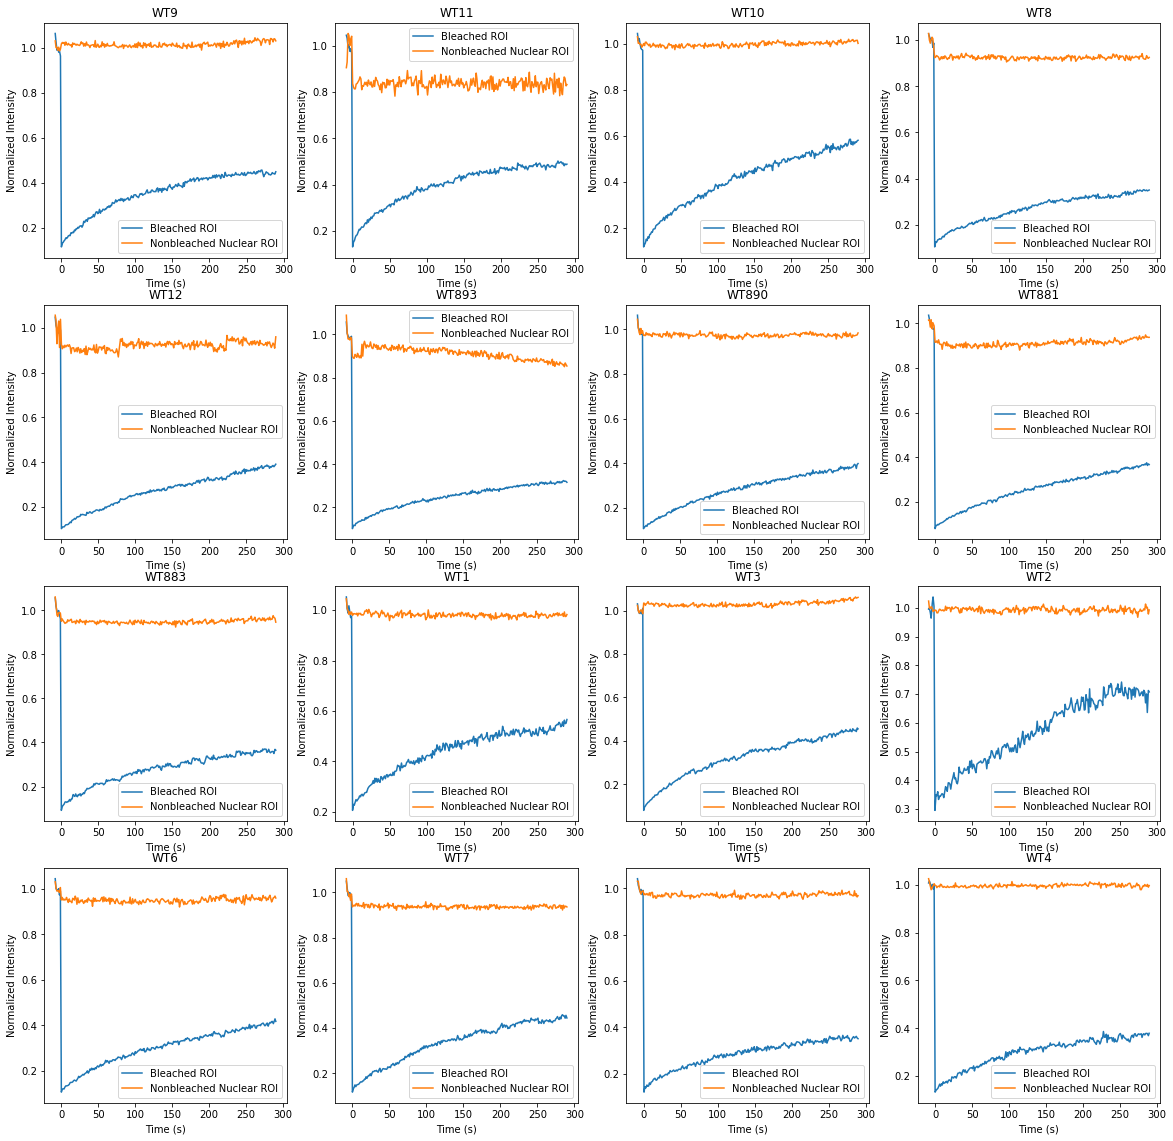

In [8]:
# Plots each individual bleach profile in a grid for every movie analyzed.

path = "" # PUT PATH TO DIRECTORY CONTAINING CSVS FOR ONE CONDITION
all_wt_gfp, names_wt_gfp = read_all_movies(path)
start_frame = 7
norm_wt_gfp = normalizeAllFRAPCurves(all_wt_gfp, start_frame)

# make plots
plot_all_plots_square(norm_wt_gfp, names_wt_gfp)

### Radial profiles
Looking at radial bleaching profiles can give a sense of how consistent the bleaching is between movies in the same condition. Additionally, it can give an idea about over bleaching and if the bleach size corresponds the the intended radius of the bleach. 

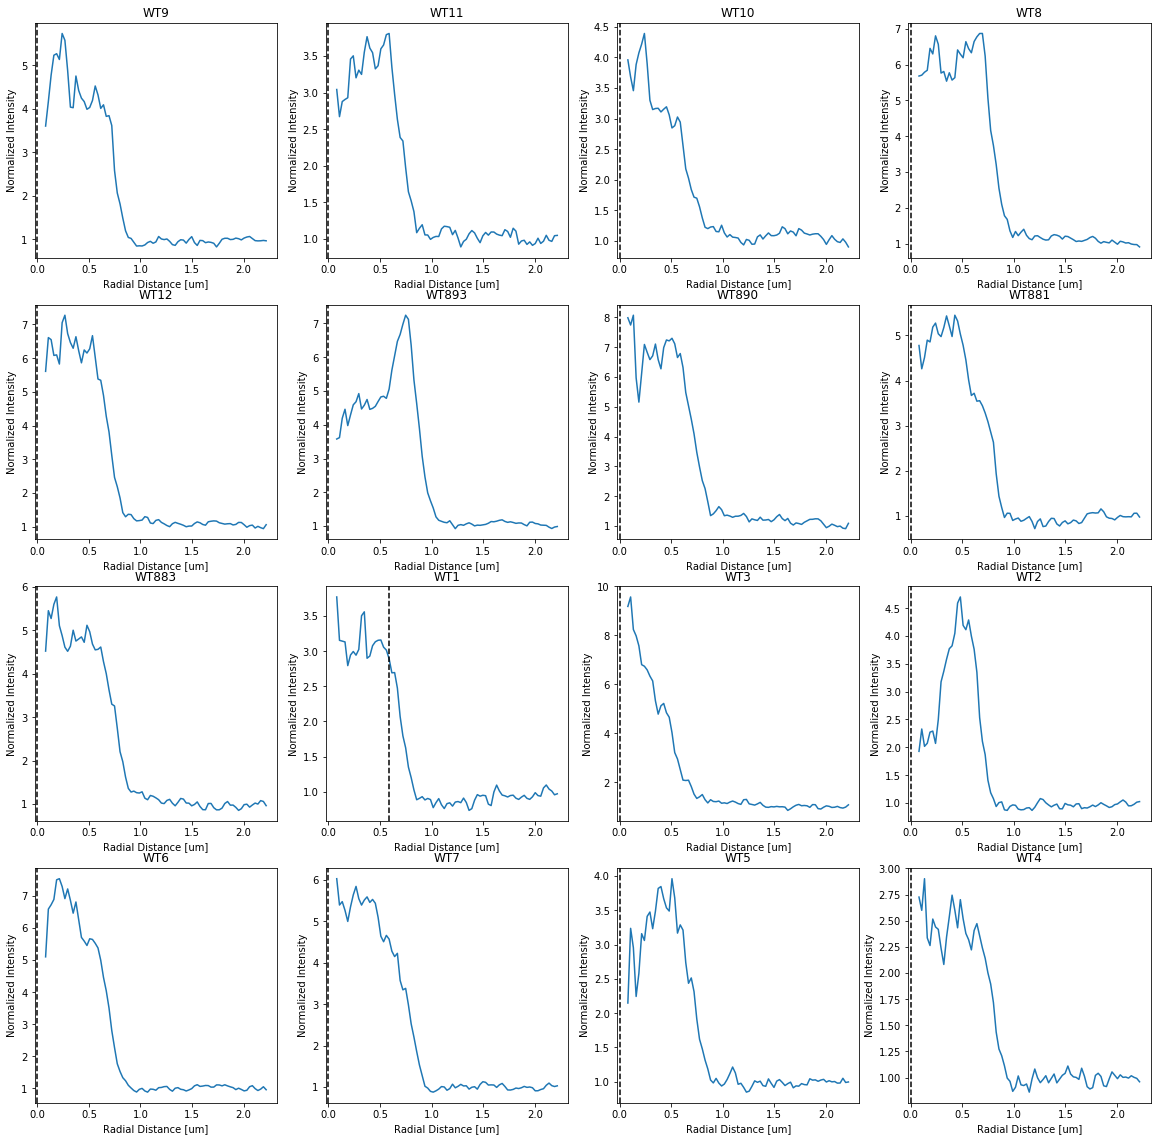

In [9]:
# Plots radial distribution of intensities for the bleach spot for every movie in a condition

plot_all_radial_profiles_square(norm_wt_gfp, names_wt_gfp)

R_C = 0.5100710538807235, sigma = 0.19040821785159637, theta = 4.689386772520089


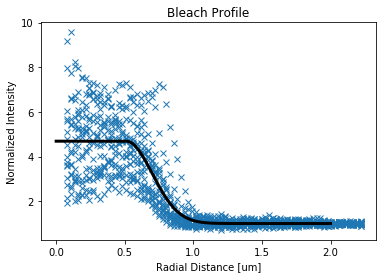

In [10]:
# Averages the radial profile across all movies. 

plot_averaged_radial_profile(norm_wt_gfp)

### QC metrics

The following QC metrics can give an idea of the consistency and quality of the datset:
- Nuclear radius: shows a histogram of the estimated nuclear radii.
- ROI radius: Shows a histogram of the ROI bleach radii obtained from the metadata of the image.
- GAP ratio: Plots a histogram of the Gap ratio. Ideally this is as low as possible indicated that there is not substantial extra bleaching in the nucleus.
- Bleaching depth: This gives an idea of the completeness of bleaching.
- Uniform radius: This plots a histogram of the minimal radius over which the bleaching is uniform. This ideally corresponds to the radius of the ROI though is subject to poor fitting. 

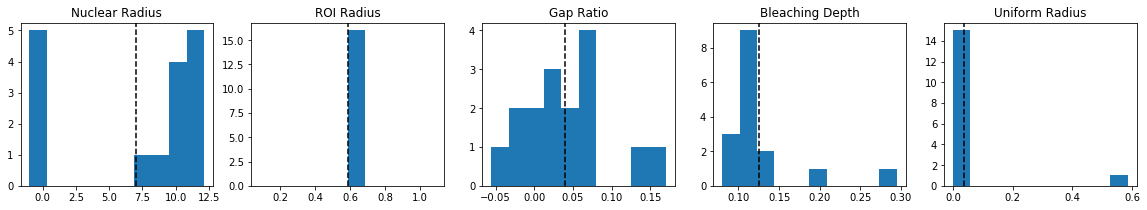

In [11]:
# Plots a set of quality control metrics for the FRAP dataset. 

plot_qc_metrics(norm_wt_gfp)

### Data model

Fits a 2-state binding model to the dataset and plots the data showing 95% confidence intervals.

k_on_1 =  0.015150653463558967 
k_off_1 =  0.014045223893205573 
k_on_2 =  0.0039046733935903413 
k_off_2 =  0.0007922861948169246 
Bound Fraction 1 =  0.15394529139490803 
Bound Fraction 2 =  0.7033416507065091 
Free Fraction =  0.14271305789858285


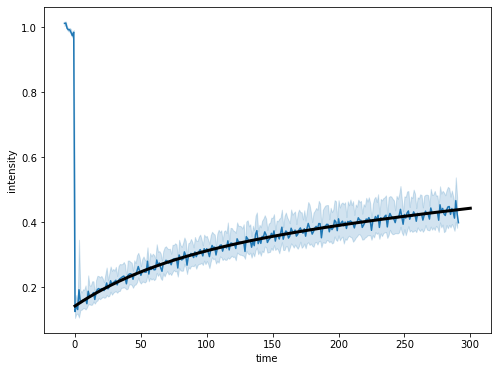

In [12]:
# Plots the averaged datset across all conditions with 95% confidence interval and a 2 bining state
# reaction model and prints the fitted parameters. 

plot_data_model(norm_wt_gfp)

In [13]:
# Performs bootstrapping routine for the fitted parameters on the datset. 

bootstrap_wt_gfp = bootstrap_multiple_datasets(norm_wt_gfp, BOOTSTRAP_SIZE, BOOTSTRAP_SAMPLES)

In [ ]:
# Plots the results of the bootstrapping routine. 

plot_bootstrapped_dataset(bootstrap_wt_gfp)

## Example comparison between FRAP conditions

Plots aggregate data with 95% confidence intervals and 2-state fitted models.

     Condition   k_off_1   k_off_2    k_on_1    k_on_2    C_1_eq    C_2_eq  \
0     WT GFI1B  0.013156  0.000759  0.014479  0.003646  0.159353  0.695855   
0  Ndel2 GFI1B  0.022415  0.001108  0.016000  0.007331  0.085701  0.794238   
0     WT CEBPA  0.058891  0.005670  0.018493  0.003578  0.161449  0.324417   
0  Ndel2 CEBPA  0.048105  0.004626  0.030650  0.002908  0.281210  0.277430   

       F_eq    Tau_r_1      Tau_r_2  
0  0.144792  76.012888  1317.964055  
0  0.120061  44.613903   902.375037  
0  0.514134  16.980393   176.358729  
0  0.441361  20.787894   216.161912  


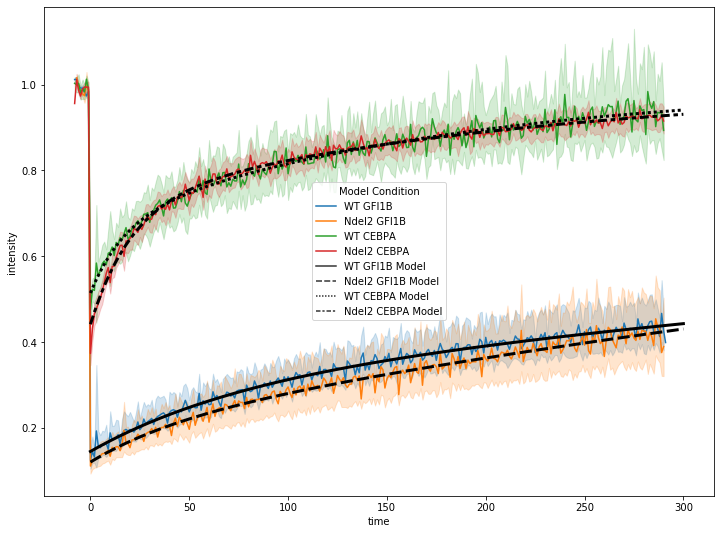

In [29]:
# Put datasets from analysis above into a list
multi_data = [norm_wt_gfp, norm_Ndel2_gfp, norm_wt_gfp_c, norm_Ndel2_gfp_c] 

# Identify the datasets with the desired names
names = ["WT GFI1B", "Ndel2 GFI1B", "WT CEBPA", "Ndel2 CEBPA"]
plot_multiple_datasets(multi_data, names, plot_model=False)


## Assess statistical significance of model parameters
The following section uses the above bootstrapping routine to estimate significance in the differences between fitted model parameters. It plots a boxplot on a per parameter basis for each of the specified conditions, and computes a p-value to assess significance in the difference between the fitted parameters. 

In [ ]:
plot_parameter_boxplot([bootstrap_norm_wt_gfp_c, bootstrap_Ndel2_gfp_c],["WT-CEBPA", "Ndel2-CEBPA"])

### Perform significance test

In [ ]:
compute_all_p_vals([bootstrap_norm_wt_gfp_c, bootstrap_Ndel2_gfp_c], 100000)

In [ ]:
plot_parameter_boxplot([bootstrap_wt_gfp, bootstrap_Ndel2_gfp],["WT-GFI1B", "Ndel2-GFI1B"])

In [ ]:
compute_all_p_vals([bootstrap_wt_gfp, bootstrap_Ndel2_gfp], 100000)